Start by importing the PyTorch components that we'll be using:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as Data

Then some standard library imports:

In [2]:
import numpy as np
import pandas as pd
import pylab as pl

---

This next cell contains all the user defined variables for running our network training.

In [3]:
valid_frac    = 0.2                 # fraction of training data to use for validation
epochs        = 100                 # number of training epochs
batch_size    = 128                 # number of samples per batch
input_size    = 8                   # The number of features
hidden_size   = 400                 # The number of nodes at the hidden layer
num_classes   = 2                   # The number of output classes. In this case, from 0 to 9
learning_rate = torch.tensor(1e-4)  # The speed of convergence
momentum      = torch.tensor(9e-1)  # momentum for optimizer
path          = "./"                # path to data set
verbose       = False               # flag for printing out stats at each epoch

In this next cell we are checking whether there is a GPU available for us to use. The `torch.cuda.is_available()` function returns a boolean (T/F), which lets us know. We can then set a `device` variable in our code that specifies which one of the available devices (GPU or CPU) we want to use. 

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
print("Device: ",device)

Device:  cpu


---

Here we define the neural network that we'll be using. This is a simple fully-connected neural network, otherwise known as a *multi-layer perceptron* (MLP). It has two hidden layers, both with the same number of neurons (`hidden_dim`). The order of the layers for a forward pass through the network is specified in the `forward` function. You can see that each fully-connected layer is followed by a [ReLU activation function](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#relu). The function then returns an unnormalised vector of outputs (`x`; also referred to as *logits*) and a vector of normalised "probabilities" for `x`, calculated using the [SoftMax function](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#softmax).

In [5]:
class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        
        self.h1  = nn.Linear(in_dim, hidden_dim)
        self.h2  = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)
        self.out_dim = out_dim

        # weight initialisation:
        # following: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
        for m in self.modules():
            if isinstance(m, nn.Linear):
                y = m.in_features
                nn.init.normal_(m.weight, 0, 1/np.sqrt(y))
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.out(x)
        
        return x, F.softmax(x, dim=1)

---

This is where the main body of the code really starts. First we load the data set. This is stored as a CSV file and contains both the *feature* data and the target class *labels*. In this next cell we read the data into a pandas data frame and separate out the features and the labels into two separate data arrays. 

In [6]:
infile = path+'pulsar.csv.gz'
htru1_df = pd.read_csv(infile, compression='gzip')
    
htru_x = htru1_df.drop('class', axis=1).values
htru_y = htru1_df['class'].values

PyTorch stores data as tensors, so we need to create data tensors from the input data arrays. Note the different data types.

We then declare that each of these data arrays is a PyTorch `Variable`. This means that PyTorch will calculate a gradient against it. If you forget to specify your data as a Variable your code will still run, but your network will not train. 

In the user defined variables at the start of this notebook we specified that we would use 20% of the data for validation. Validation data is typically used to assess the performance of the network and tune the hyper-parameters (`epochs`, `learning_rate`, `momentum`, etc.) Sometimes people use the terms *validation* and *test* interchangeably, but strictly speaking the validation data should be data used to tune the network and the test data should remain completely unseen by the network until you want to put it to use.  

There are lots of ways to split your data in PyTorch. Here we're using the `random_split` function, but the `Subset` and `SubsetRandomSampler` from `torch.utils.data.sampler` are also popular choices.

Here we're making use of the PyTorch `DataLoader` functionality. This is going to be useful later when we want to load data during our training loop.

In [7]:
htru_x  = torch.tensor(htru_x, dtype=torch.float)
htru_y  = torch.tensor(htru_y, dtype=torch.long)

x, y = Variable(htru_x), Variable(htru_y)
full_dataset = Data.TensorDataset(x, y)

valid_size = int(valid_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_loader = Data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

valid_loader = Data.DataLoader(dataset=valid_dataset,
                               batch_size=batch_size,
                               shuffle=True)

Next we need to specify that we're using the `Classifier_MLP` model that we specified above and pass it the parameters it requires (`input_size`, `hidden_dim`, `out_dim`). 

We also specify which optimizer we'll use to train our network. Here I've implemented a classic [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) optimiser, but there are [a wide range of optimizers available in the PyTorch library](https://pytorch.org/docs/stable/optim.html#algorithms). For most recent applications the [Adam](https://arxiv.org/abs/1412.6980) optimizer is used.

In [8]:
model = Classifier_MLP(in_dim=input_size, hidden_dim=hidden_size, out_dim=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

The next cell contains the training loop for optimizing the parameters of our neural network. To train the network we loop through the full training data set multiple times. Each loop is called an *epoch*. However, we don't read the full dataset all at once in an individual epoch, instead we split it into *mini-batches* and we use the optimization algorithm to update the network parameters after each batch. 

The `train_loader` that we specified earlier using the PyTorch `DataLoader` breaks up the full dataset into batches automatically and allows us to load the feature data (`x_train`) and the label data (`y_train`) for each batch separately. Moreover, because we specified `shuffle=True` when we defined the `train_loader` the full datasets will be shuffled on each epoch, so that we aren't optimising over an identical sequence of samples in every loop. 

PyTorch models (`nn.Module`) can be set into either training or evaluation mode. For the loop we've defined here this setting does not make any difference as we do not use any layers that perform differently during evaluation (e.g. dropout, batch normalisation, etc. ) However, it's included here for completeness. 

In [11]:
%%time

epoch_trainaccs, epoch_validaccs = [], []
epoch_trainloss, epoch_validloss = [], []

for epoch in range(epochs):  # loop over the dataset multiple times

    # training loop for this epoch
    model.train() # set the model into training mode
    
    train_loss, train_accs=[],[]; acc = 0
    for batch, (x_train, y_train) in enumerate(train_loader):
        
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        model.zero_grad()
        pred, prob = model(x_train)
        
        acc = (prob.argmax(dim=-1) == y_train).to(torch.float32).mean()
        train_accs.append(acc.mean().item())
        
        loss = F.cross_entropy(pred, y_train)
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

    if verbose:
        print('Epoch: {}, Train Loss: {:4f}'.format(epoch, np.mean(train_loss), np.mean(train_accs)))

    # validation loop for this epoch:
    model.eval() # set the model into evaluation mode
    with torch.no_grad():  # turn off the gradient calculations
        
        valid_loss, valid_accs = [], []; acc = 0
        for i, (x_valid, y_valid) in enumerate(valid_loader):
            
            x_valid, y_valid = x_valid.to(device), y_valid.to(device)
            
            pred, prob = model(x_valid)
            
            loss = F.cross_entropy(pred, y_valid)
            
            acc = (prob.argmax(dim=-1) == y_valid).to(torch.float32).mean()
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

    if verbose:
        print('Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(np.mean(valid_loss), np.mean(valid_accs)))

    epoch_trainaccs.append(np.mean(train_accs))
    epoch_validaccs.append(np.mean(valid_accs))

    epoch_trainloss.append(np.mean(train_loss))
    epoch_validloss.append(np.mean(valid_loss))

print('Finished Training')
print("Final validation error: ",100.*(1 - epoch_validaccs[-1]),"%")

Finished Training
Final validation error:  2.235545430864605 %
CPU times: user 1min 25s, sys: 623 ms, total: 1min 25s
Wall time: 47.2 s


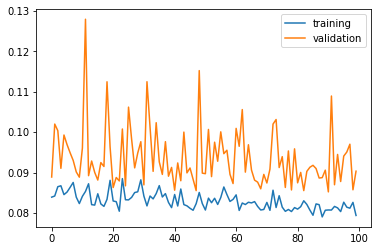

In [12]:
pl.subplot(111)
pl.plot(epoch_trainloss, label="training")
pl.plot(epoch_validloss, label="validation")
pl.legend()
pl.show()